First coembedding

In [2]:
from coembedding.function import co_embedding
import numpy as np
import scanpy as sc
import pandas as pd
import datatable as dt
import math
import os
import seaborn as sns

In [5]:
DataDir="./data/pseudo_STData/dataset12(14)/"
sc_file_path = DataDir+'scRNA.h5ad'
RNA_data_adata = sc.read_h5ad(sc_file_path)
#RNA_data_adata.obs['celltype']=RNA_data_adata.obs['celltype_final']
Spatial_file = DataDir + 'Insitu_count.txt'
location_file = DataDir + 'Locations.txt'
Spatial_data_adata = sc.read(Spatial_file, sep = '\t')
locations = pd.read_csv(location_file,sep='\t')
Spatial_data_adata.obs=locations

print(RNA_data_adata)
print(Spatial_data_adata)

AnnData object with n_obs × n_vars = 14249 × 34041
    obs: 'celltype'
AnnData object with n_obs × n_vars = 1154 × 42
    obs: 'x', 'y', 'z'


In [ ]:
adata = co_embedding(data_list=[RNA_data_adata,Spatial_data_adata],outdir=DataDir)
adata_path=DataDir+"simulate_co_adata.h5ad"
#adata.write(adata_path)

In the second step, the co-embedded single-cell data and idling data are separated, and 'latent' represents the feature output by the encoder

In [2]:
DataDir="data/pseudo_STData/dataset12(14)/"
co_adata=sc.read_h5ad(DataDir+'simulate_co_adata.h5ad')
df_id = co_adata.obs['celltype']
co_adata.obs.insert(0,'celltype_final',df_id)
co_adata.obs=co_adata.obs.rename(columns={'X':'x','Y':'y'})
print(co_adata)

AnnData object with n_obs × n_vars = 14977 × 42
    obs: 'celltype_final', 'celltype', 'x', 'y', 'z', 'batch', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'batch_colors', 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_umap', 'latent'
    obsp: 'connectivities', 'distances'


In [3]:
sc_data=co_adata[co_adata.obs['batch']=="0"]
st_data=co_adata[co_adata.obs['batch']=="1"]
print(sc_data)
print(st_data)
celltype_counts = sc_data.obs['celltype'].value_counts()
print(len(celltype_counts))

View of AnnData object with n_obs × n_vars = 13823 × 42
    obs: 'celltype_final', 'celltype', 'x', 'y', 'z', 'batch', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'batch_colors', 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_umap', 'latent'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 1154 × 42
    obs: 'celltype_final', 'celltype', 'x', 'y', 'z', 'batch', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'batch_colors', 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_umap', 'latent'
    obsp: 'connectivities', 'distances'
15


According to the coordinate position of the ST data, use the K nearest neighbor regression algorithm to infer the possible coordinate position of each cell in the single-cell data

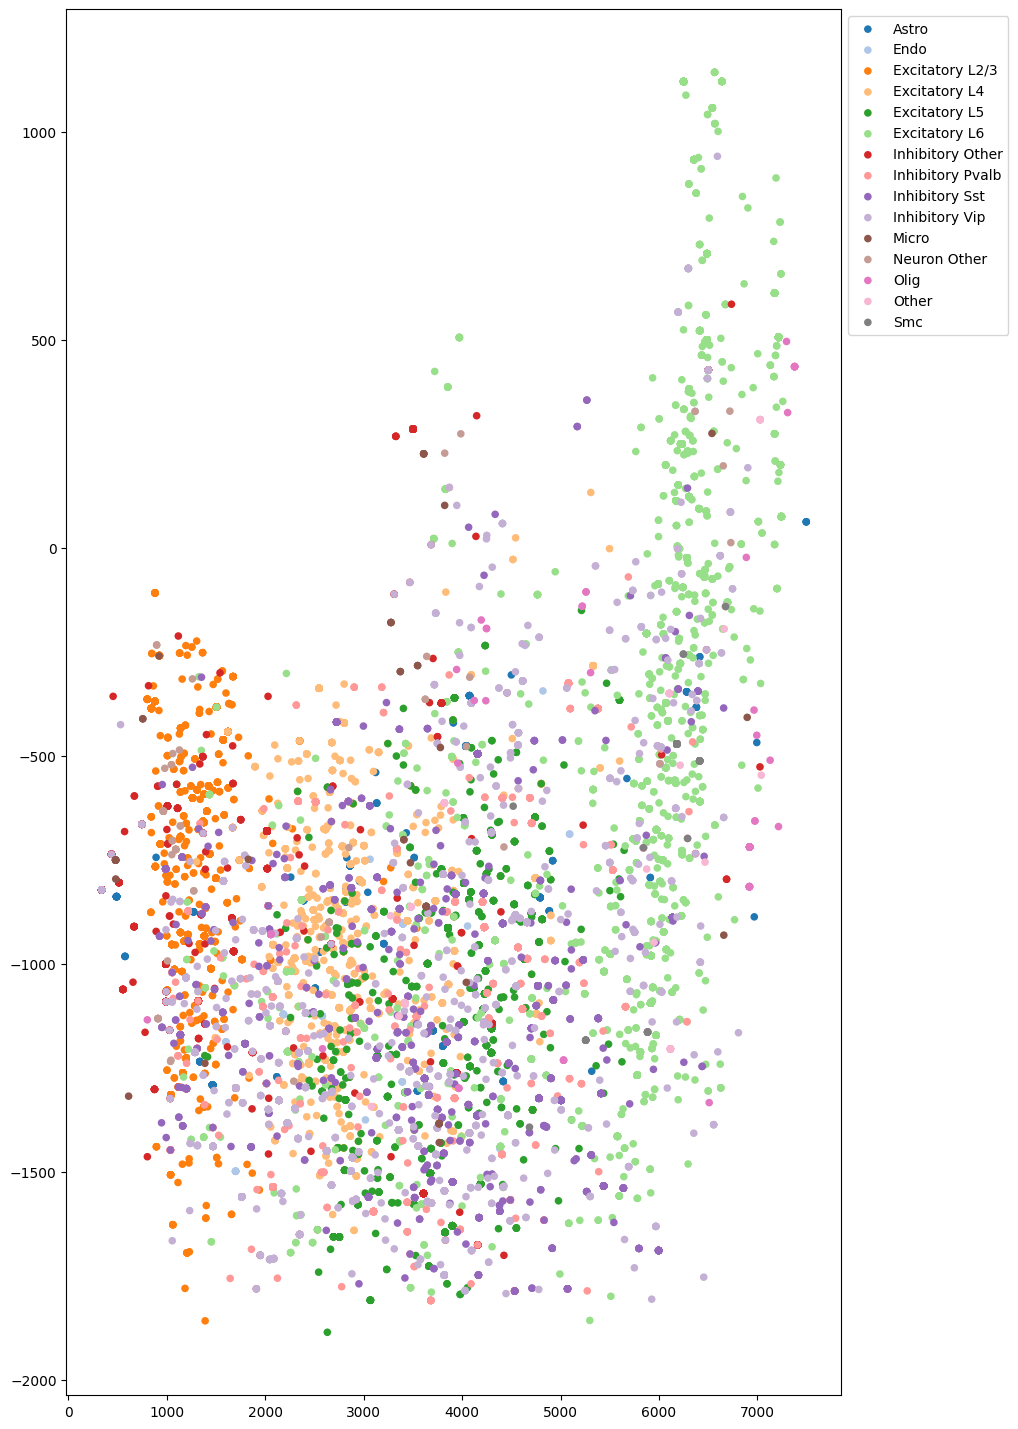

In [4]:

from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

sc_meta=sc_data.obs.copy()
print(sc_meta)

X_train1=st_data.obsm['latent']
y_train1=np.array(st_data.obs[["x","y"]]).astype("int")
X_test1=sc_data.obsm['latent']
knn = knn = KNeighborsRegressor(n_neighbors=2).fit(X_train1, y_train1)
y_test1 = knn.predict(X_test1)

sc_meta["x"]=y_test1[:,0]
sc_meta["y"]=y_test1[:,1]

fig,ax = plt.subplots(figsize=(10,18))
cmap = sns.color_palette('tab20',n_colors=len(np.unique(np.array(sc_meta.celltype))))
for i,c in enumerate(np.unique(sc_meta.celltype_final)):
    ax.scatter(x=sc_meta[sc_meta['celltype_final'] == c]['x'],y=sc_meta[sc_meta['celltype_final'] == c]['y'],
               c=matplotlib.colors.to_hex(cmap[i]),label=c,s=30,marker='o',edgecolors='none')
ax.legend(bbox_to_anchor=(1,1))
plt.yticks(np.arange(-2000,1400,500))
plt.xticks(np.arange(0,8000,1000))
plot_file = os.path.join(DataDir+"results/raw_simu2.pdf")
fig.savefig(plot_file,dpi=600,bbox_inches = "tight")
plt.show()

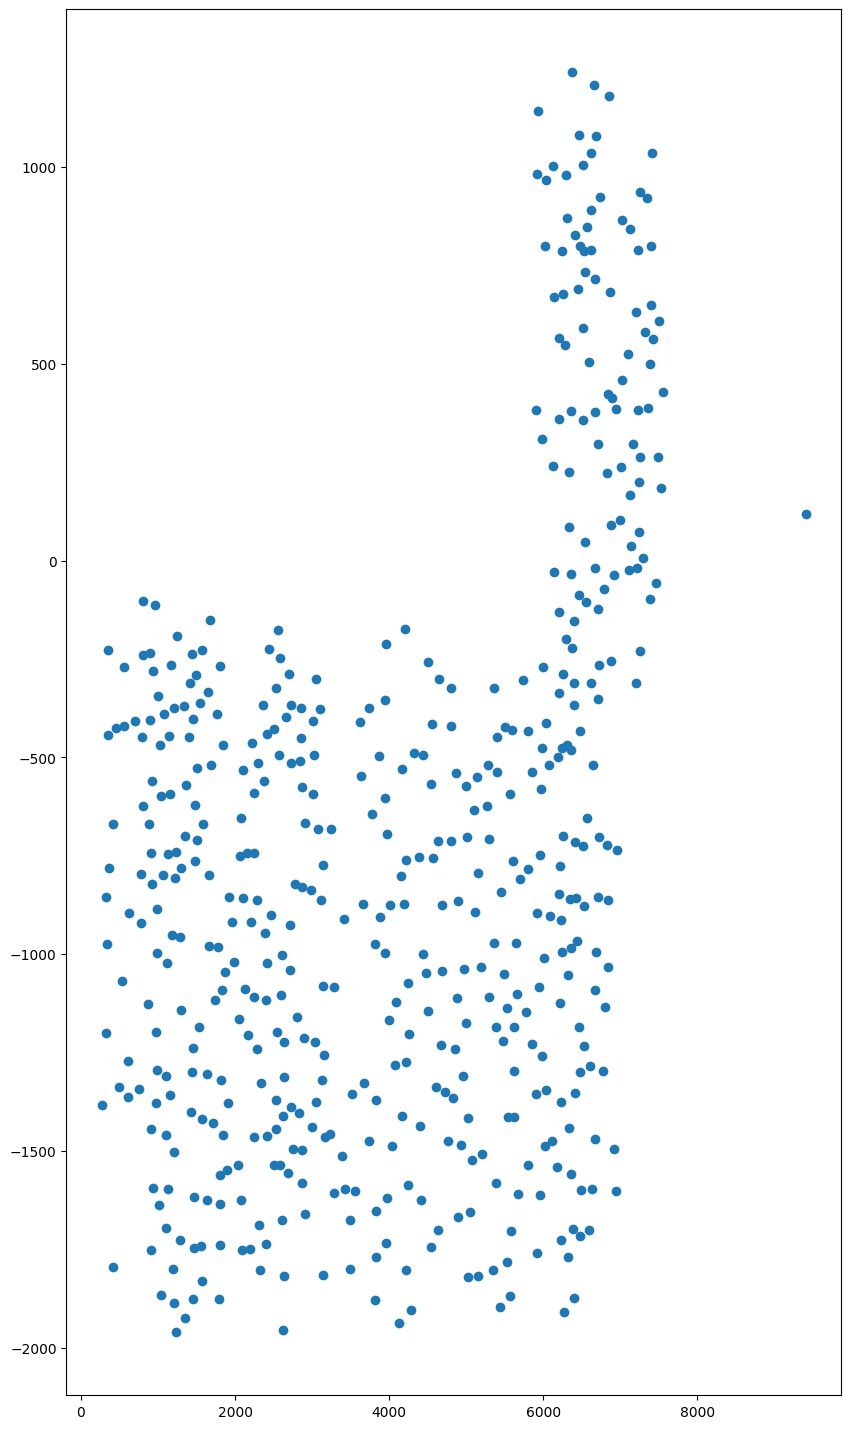

In [5]:
fig,ax = plt.subplots(figsize=(10,18))
ax.scatter(x=y_train1[:,0],y=y_train1[:,1])
plt.show()

To simulate idling data with single-cell data with coordinates, use honeycomb hexagonal spots

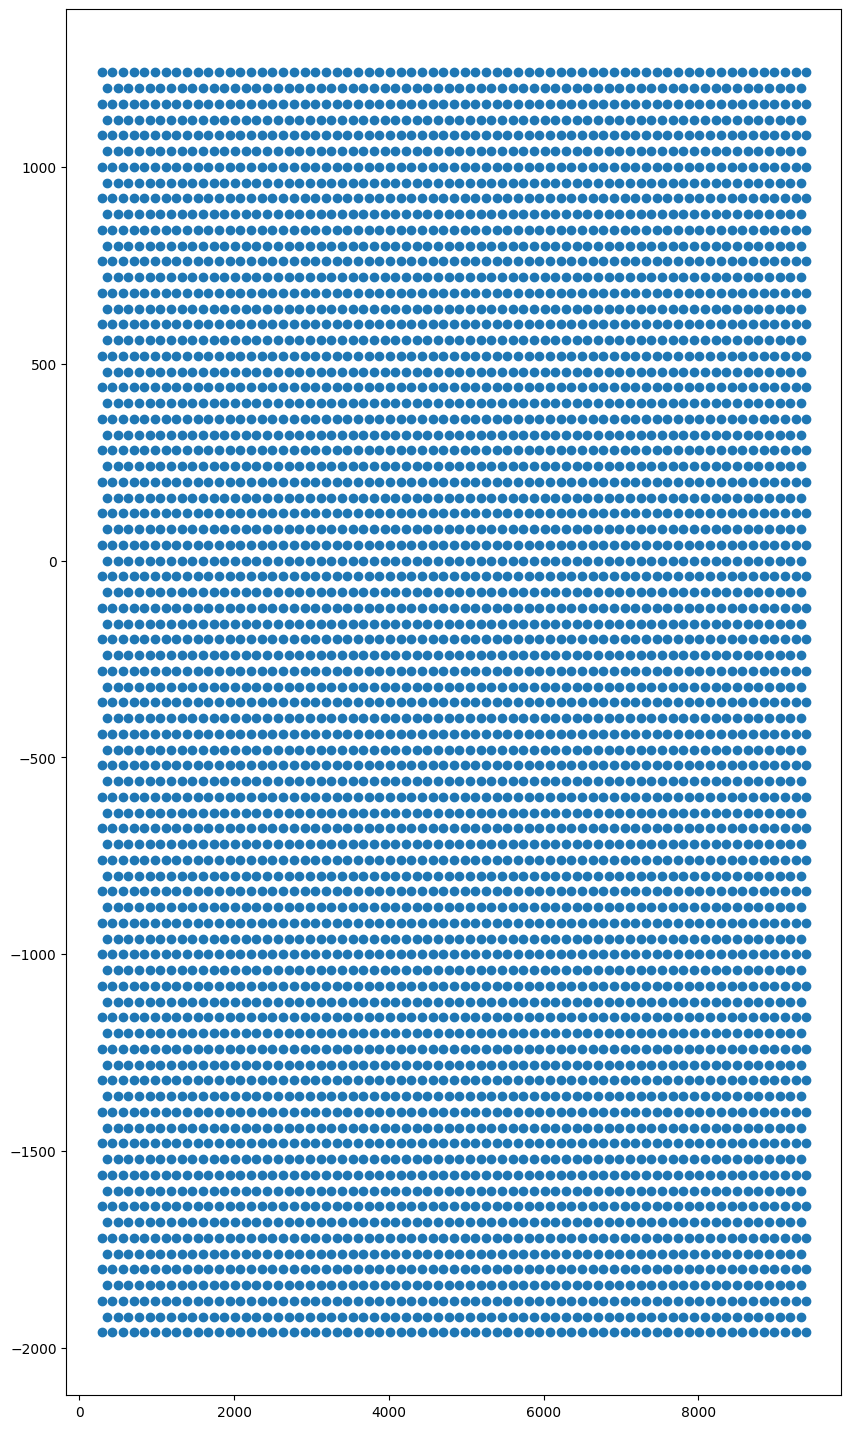

In [6]:
import math

x=y_train1[:,0]
y=y_train1[:,1]
ori_xy=[(min(x)+max(x))/2,(min(y)+max(y))/2]
height=80
trans=[[0,height],[int(height*math.sqrt(3)/2),height/2],[int(height*math.sqrt(3)/2),-height/2],
       [0,-height],[-int(height*math.sqrt(3)/2),-height/2],[-int(height*math.sqrt(3)/2),height/2]]

xy=[ori_xy]
do_ceter=0
for k,pos1 in enumerate(xy):
    if k>=do_ceter:
        do_ceter=k
        for i in range(len(trans)):
                xn=pos1[0]+trans[i][0]
                yn=pos1[1]+trans[i][1]
                if xn>=min(x) and xn<=max(x) and yn>=min(y) and yn<=max(y):
                        if [xn,yn] not in xy:
                                xy.append([xn,yn])
xy=np.array(xy)
fig,ax = plt.subplots(figsize=(10,18))
ax.scatter(x=xy[:,0],y=xy[:,1])
plt.show()

(14249, 2)


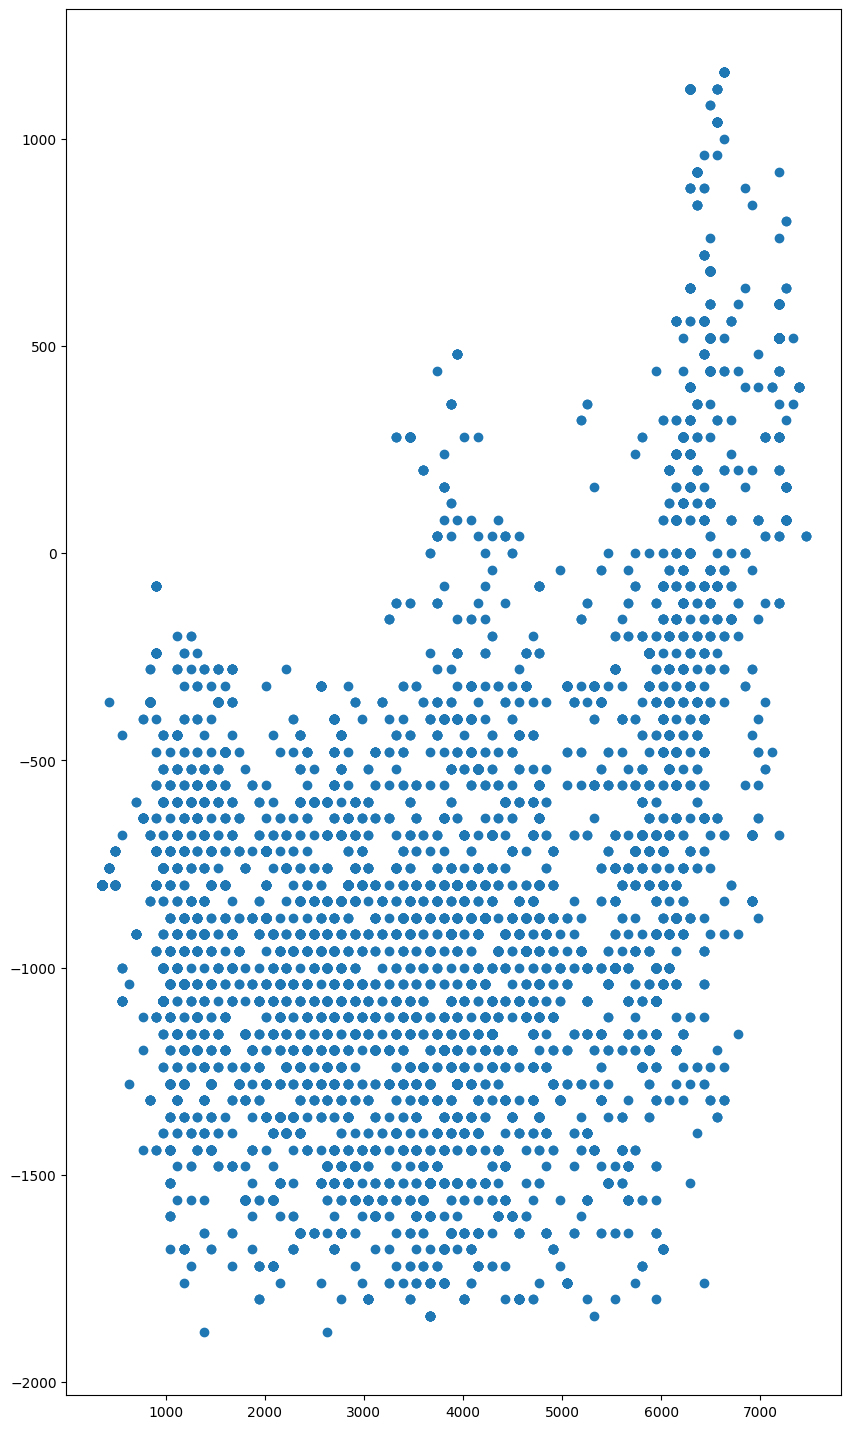

In [7]:
from sklearn.neighbors import KNeighborsClassifier
X_train2=xy
X_test2=y_test1
knn = knn = KNeighborsClassifier(n_neighbors=1).fit(X_train2,X_train2.astype("int"))
y_test2 = knn.predict(X_test2)
print(y_test2.shape)
fig,ax = plt.subplots(figsize=((10,18)))
ax.scatter(x=y_test2[:,0],y=y_test2[:,1])
plt.show()

In [8]:
sc_data.obs["x"]=y_test2[:,0]
sc_data.obs["y"]=y_test2[:,1]
sc_data.obs["x"]=sc_data.obs["x"].astype("int")
sc_data.obs["y"]=sc_data.obs["y"].astype("int")
sc_data.obs["index"]=range(len(sc_data.obs["x"]))
print(sc_data.obs)

                       celltype_final          celltype     x     y batch  \
F1S4_160108_001_A01    Inhibitory Vip    Inhibitory Vip  2978 -1440     0   
F1S4_160108_001_B01  Inhibitory Other  Inhibitory Other  2012  -720     0   
F1S4_160108_001_C01  Inhibitory Other  Inhibitory Other  3944 -1280     0   
F1S4_160108_001_D01    Inhibitory Vip    Inhibitory Vip  4496 -1360     0   
F1S4_160108_001_E01  Inhibitory Other  Inhibitory Other  4289 -1160     0   
...                               ...               ...   ...   ...   ...   
FYS4_171004_104_C01     Excitatory L5     Excitatory L5  3875  -920     0   
FYS4_171004_104_D01    Inhibitory Sst    Inhibitory Sst  3806 -1200     0   
FYS4_171004_104_F01     Excitatory L5     Excitatory L5  2978 -1200     0   
FYS4_171004_104_G01    Inhibitory Sst    Inhibitory Sst  4151 -1400     0   
FYS4_171004_104_H01  Inhibitory Pvalb  Inhibitory Pvalb  1943 -1080     0   

                     n_genes  index  
F1S4_160108_001_A01      640      0  

/tmp/ipykernel_27384/3203745033.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_data.obs["x"]=y_test2[:,0]


Make the number of cells on each spot between 4-15

In [9]:
df=sc_data.obs
df1 = df.groupby(["x","y"]).apply(lambda x: list(x["index"])).tolist()
print(len(df1))

count1=0
maxl=0
for li in df1:
    if len(li)>maxl:
        maxl=len(li)
    if len(li)<=3:
        count1 += 1
print(count1)
print(maxl)

1301
653
491


In [10]:
import random
x=y_train1[:,0]
y=y_train1[:,1]
trans=[[0,height],[int(height*math.sqrt(3)/2),height/2],[int(height*math.sqrt(3)/2),-height/2],
       [0,-height],[-int(height*math.sqrt(3)/2),-height/2],[-int(height*math.sqrt(3)/2),height/2]]
for _ in range(len(df1)):
    change1=0
    change2=0
    for li in df1:
        if len(li)>15:
            change1=1
            a=df.iloc[li]
            #print(a)
            for i in range(len(li)-15):
                r=random.randint(0,5)
                new_x=a.iloc[15+i,2]+trans[r][0]
                new_y=a.iloc[15+i,3]+trans[r][1]
                if new_x>=min(x) and new_x<=max(x) and new_y>=min(y) and new_y<=max(y):
                    a.iloc[15+i,2:4]+=trans[r]
                else:
                    a.iloc[15+i,2:4]+=trans[(r+3)%6]
            df.iloc[li]=a
    df1 = df.groupby(["x","y"]).apply(lambda x: list(x["index"])).tolist()
      
    for li in df1:        
        if len(li)<4:
            change2=1
            a=df.iloc[li]
            for i in range(len(li)):
                r=random.randint(0,5)
                new_x=a.iloc[i,2]+trans[r][0]
                new_y=a.iloc[i,3]+trans[r][1]
                if new_x>=min(x) and new_x<=max(x) and new_y>=min(y) and new_y<=max(y):
                    a.iloc[i,2:4]+=trans[r]
                else:
                    a.iloc[i,2:4]+=trans[(r+3)%6]
            df.iloc[li]=a
    df1 = df.groupby(["x","y"]).apply(lambda x: list(x["index"])).tolist() 
    if change1==0 and change2==0:
        break

In [11]:
filted_df = df.groupby(["x","y"]).filter(lambda x: len(x)>3)
print(filted_df)
cell2spots = filted_df.groupby(["x","y"]).apply(lambda x: list(x["index"])).tolist()
print(len(cell2spots))
count1=0
maxl=0
for li in cell2spots:
    if len(li)>maxl:
        maxl=len(li)
    if len(li)<=3:
        count1 += 1
print(count1)
print(maxl)

                       celltype_final          celltype     x     y batch  \
F1S4_160108_001_A01    Inhibitory Vip    Inhibitory Vip  2978 -1440     0   
F1S4_160108_001_B01  Inhibitory Other  Inhibitory Other  2012  -720     0   
F1S4_160108_001_C01  Inhibitory Other  Inhibitory Other  3944 -1280     0   
F1S4_160108_001_D01    Inhibitory Vip    Inhibitory Vip  4496 -1360     0   
F1S4_160108_001_E01  Inhibitory Other  Inhibitory Other  4289 -1160     0   
...                               ...               ...   ...   ...   ...   
FYS4_171004_104_C01     Excitatory L5     Excitatory L5  5255 -1160     0   
FYS4_171004_104_D01    Inhibitory Sst    Inhibitory Sst  3047  -920     0   
FYS4_171004_104_F01     Excitatory L5     Excitatory L5  2909 -1240     0   
FYS4_171004_104_G01    Inhibitory Sst    Inhibitory Sst  5048 -1360     0   
FYS4_171004_104_H01  Inhibitory Pvalb  Inhibitory Pvalb  2081 -1080     0   

                     n_genes  index  
F1S4_160108_001_A01      640      0  

In [12]:
print(filted_df)

                       celltype_final          celltype     x     y batch  \
F1S4_160108_001_A01    Inhibitory Vip    Inhibitory Vip  2978 -1440     0   
F1S4_160108_001_B01  Inhibitory Other  Inhibitory Other  2012  -720     0   
F1S4_160108_001_C01  Inhibitory Other  Inhibitory Other  3944 -1280     0   
F1S4_160108_001_D01    Inhibitory Vip    Inhibitory Vip  4496 -1360     0   
F1S4_160108_001_E01  Inhibitory Other  Inhibitory Other  4289 -1160     0   
...                               ...               ...   ...   ...   ...   
FYS4_171004_104_C01     Excitatory L5     Excitatory L5  5255 -1160     0   
FYS4_171004_104_D01    Inhibitory Sst    Inhibitory Sst  3047  -920     0   
FYS4_171004_104_F01     Excitatory L5     Excitatory L5  2909 -1240     0   
FYS4_171004_104_G01    Inhibitory Sst    Inhibitory Sst  5048 -1360     0   
FYS4_171004_104_H01  Inhibitory Pvalb  Inhibitory Pvalb  2081 -1080     0   

                     n_genes  index  
F1S4_160108_001_A01      640      0  

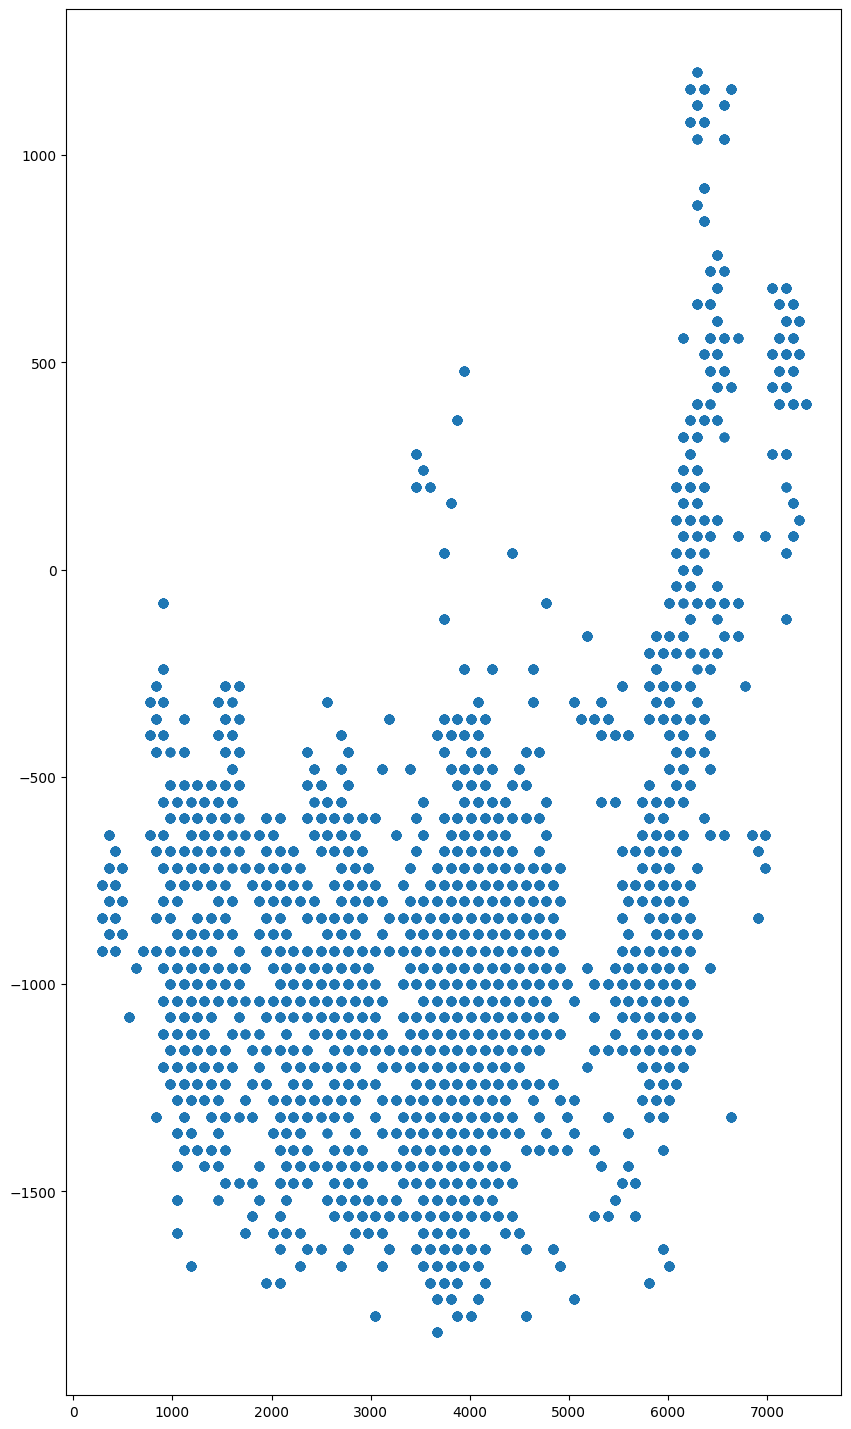

In [13]:
fig,ax = plt.subplots(figsize=(10,18))
ax.scatter(x=filted_df.iloc[:,2],y=filted_df.iloc[:,3])
plt.show()

Simulate the generation of spatial transcriptome array data, and generate a map matrix and save it in uns['density']

In [14]:
sc_file_path = DataDir+'scRNA.h5ad'
RNA_data_adata = sc.read_h5ad(sc_file_path)

Spatial_file = DataDir + 'Insitu_count.txt'
location_file = DataDir + 'Locations.txt'
Spatial_data_adata = sc.read(Spatial_file, sep = '\t')
locations = pd.read_csv(location_file,sep='\t')
Spatial_data_adata.obs=locations

# intersect = np.intersect1d(RNA_data_adata.var_names, Spatial_data_adata.var_names)
new_sc_adata=RNA_data_adata.copy()
#sc.pp.normalize_total(new_sc_adata)
st_X=np.zeros((len(cell2spots),new_sc_adata.X.shape[1]))
spots_name=[i for i in range(len(cell2spots))]
map_matrix=pd.DataFrame(np.zeros((len(cell2spots),len(new_sc_adata.obs["celltype"].unique()))),
                        index=spots_name, columns=new_sc_adata.obs["celltype"].unique())


spots_x=[]
spots_y=[]
for i,idx in enumerate(cell2spots):
    st_X[i,:]=new_sc_adata.X[idx,:].sum(0)
    spots_x.append(filted_df["x"].loc[filted_df["index"]==idx[0]].values[0])
    spots_y.append(filted_df["y"].loc[filted_df["index"]==idx[0]].values[0])
    for j in idx:
        map_matrix.loc[spots_name[i],filted_df["celltype"].loc[filted_df["index"]==j]] += 1

st_data_obs=pd.DataFrame(index=spots_name)
st_data_obs["X"]=spots_x
st_data_obs["Y"]=spots_y
new_st_adata=sc.AnnData(st_X,obs=st_data_obs,var=new_sc_adata.var)
new_st_adata.uns['density']=map_matrix

/tmp/ipykernel_27384/1905921795.py:31: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  new_st_adata=sc.AnnData(st_X,obs=st_data_obs,var=new_sc_adata.var)
/opt/miniconda3/envs/yw/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
print(new_st_adata)
print(new_st_adata.obs)

AnnData object with n_obs × n_vars = 1026 × 34041
    obs: 'X', 'Y'
    uns: 'density'
         X    Y
0      287 -920
1      287 -840
2      287 -760
3      356 -880
4      356 -800
...    ...  ...
1021  7256  640
1022  7325  120
1023  7325  520
1024  7325  600
1025  7394  400

[1026 rows x 2 columns]


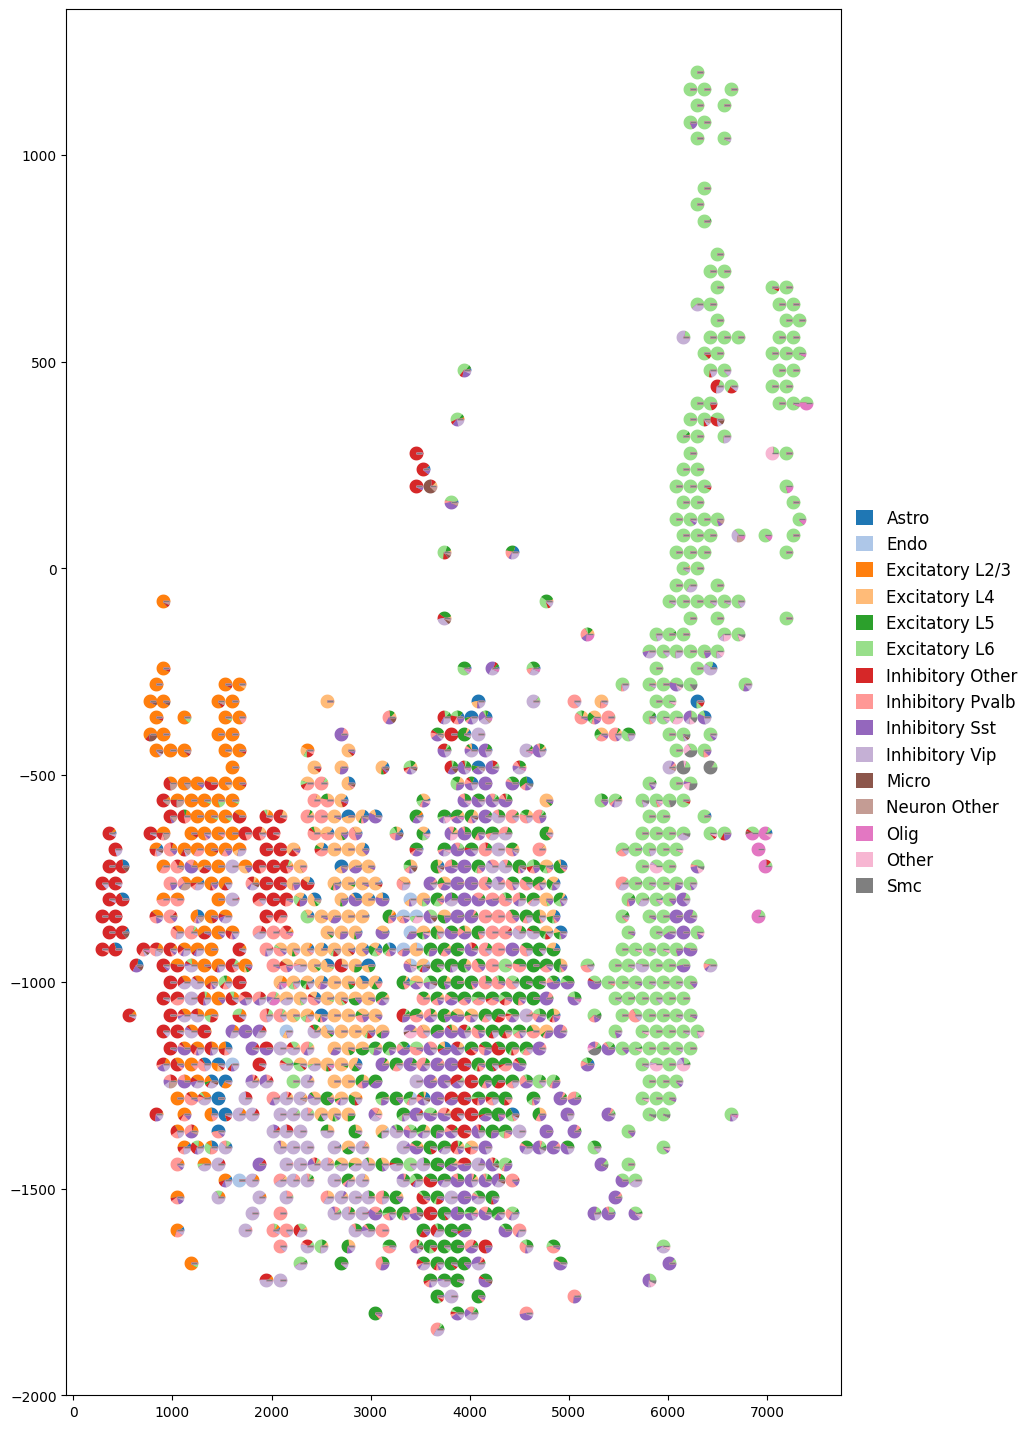

In [20]:
st_deconv_df = map_matrix.copy()
st_deconv_df = (st_deconv_df.T/st_deconv_df.sum(axis=1)).T
st_deconv_df = st_deconv_df.loc[:,np.unique(st_deconv_df.columns)]
st_deconv_df = st_deconv_df.fillna(0)
st_loc_df=new_st_adata.obs.copy()

import matplotlib.patches as mpatches

def PieMarker(loc_list, frac_list, size, color_list):
    '''
    Return marker list for a point
    '''
    frac_cumsum = np.cumsum(frac_list)
    frac_cumsum = frac_cumsum/frac_cumsum[-1]
    marker_list = []
    previous = 0
    # calculate the points of the pie pieces
    for color, frac in zip(color_list, frac_cumsum):
        curr = frac
        x  = np.cos(2 * np.pi * np.linspace(previous, curr, 50)).tolist()
        y  = np.sin(2 * np.pi * np.linspace(previous, curr, 50)).tolist()
        xy = np.row_stack([[0, 0], np.column_stack([x, y])])
        marker_list.append({'marker': xy, 's': size*np.abs(xy).max()**2, 'facecolor': color, 'edgecolor': "darkgrey", 'linewidth': 0.0001})
        previous = frac
    # scatter each of the pie pieces to create pies
    point_marker_list = []
    for marker in marker_list:
        point_marker_list.append(loc_list + [marker])
    return(point_marker_list)

DefaulfColorPalette = [
    "#1F77B4", "#AEC7E8", "#FF7F0E", "#FFBB78", "#2CA02C", "#98DF8A",
    "#D62728", "#FF9896", "#9467BD", "#C5B0D5", "#8C564B", "#C49C94",
    "#E377C2", "#F7B6D2", "#7F7F7F", "#FF9DA6", "#778AAE", "#1B9E77",
    "#A6761D", "#526A83", "#B82E2E", "#80B1D3", "#68855C", "#D95F02",
    "#BEBADA", "#AF6458", "#D9AF6B", "#9C9C5E", "#625377", "#8C785D",
    "#88CCEE", "#E73F74", "#FFFFB3", "#CCEBC5", "#332288", "#A65628"
]
color_pal = DefaulfColorPalette

pt_size=9

fig = plt.figure(figsize=(10,18))
ax = fig.add_subplot()
for i in st_deconv_df.index:
    deconv_list = st_deconv_df.iloc[i,:]
    loc_list = st_loc_df.iloc[i,:].tolist()
    point_marker_list = PieMarker(loc_list[0:2], deconv_list, pt_size**2, color_pal)
    for point_marker in point_marker_list:
        ax.scatter(point_marker[0], point_marker[1], **point_marker[-1])
# add legends
celltypes = st_deconv_df.columns
patch_list = []
for i in range(len(celltypes)):
    patch_list.append(mpatches.Patch(facecolor = color_pal[i], label = celltypes[i], edgecolor = "darkgrey", linewidth=0.001))
ax.legend(handles = patch_list, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '12', frameon = False,
    handlelength=1, handleheight=1)
# ax.axis('equal')
# ax.set_xlabel(st_loc_df.columns[0])
# ax.set_ylabel(st_loc_df.columns[1])
#ax.set_title(out_prefix, pad = 15)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.yticks(np.arange(-2000,1400,500))
plt.xticks(np.arange(0,8000,1000))
# save figure
plot_file = os.path.join(DataDir+"results/portion_simu2.pdf")
fig.savefig(plot_file,dpi=600,bbox_inches = "tight")
plt.show(fig)

In [17]:
# sp_file_path = DataDir+'Spatial.h5ad'
# new_st_adata.write(sp_file_path)

In [18]:
print(map_matrix.sum(1))

0       14.0
1       15.0
2       15.0
3       15.0
4       15.0
        ... 
1021    15.0
1022     8.0
1023    15.0
1024    15.0
1025    14.0
Length: 1026, dtype: float64
